In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [2]:
import imageio.v3 as iio
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [4]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


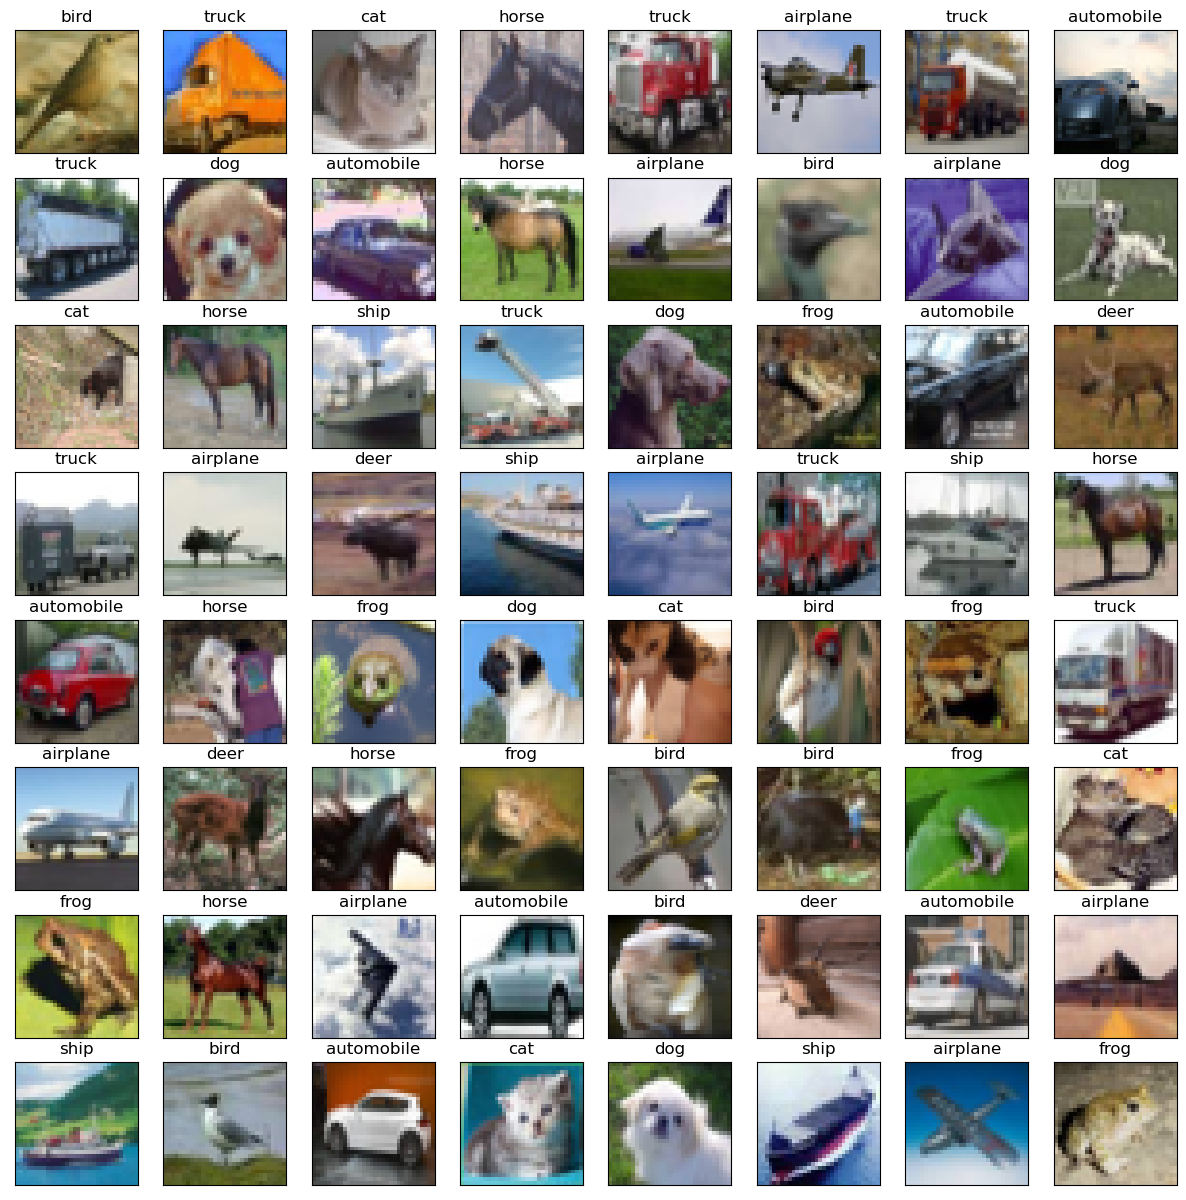

In [5]:
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
               
# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(X_train[i])

    # Set the label as the title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

In [6]:
# Convert pixel values data type to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train)
std  = np.std(X_train)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

In [7]:
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

In [8]:
# Data augmentation
data_generator = ImageDataGenerator(
    # Rotate images randomly by up to 15 degrees
    rotation_range=15,
    
    # Shift images horizontally by up to 12% of their width
    width_shift_range=0.12,
    
    # Shift images vertically by up to 12% of their height
    height_shift_range=0.12,
    
    # Randomly flip images horizontally
    horizontal_flip=True,
    
    # Zoom images in by up to 10%
    zoom_range=0.1,
    
    # Change brightness by up to 10%
    brightness_range=[0.9,1.1],

    # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=10,
    
    # Channel shift intensity
    channel_shift_range=0.1,
)

In [9]:
# Initialize a sequential model
model = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay), 
                 input_shape=X_train.shape[1:]))
# Add batch normalization layer
model.add(BatchNormalization())

# Add the second convolutional layer similar to the first
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the first max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))

# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))   
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(10, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [11]:
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [12]:
history=model.fit(X_train, y_train, epochs=50, batch_size=64,validation_data=(X_valid, y_valid))

Epoch 1/50
704/704 [==============================] - 754s 1s/step - loss: 2.1072 - accuracy: 0.4233 - val_loss: 2.0971 - val_accuracy: 0.4152
Epoch 2/50
704/704 [==============================] - 743s 1s/step - loss: 1.4214 - accuracy: 0.5995 - val_loss: 1.2704 - val_accuracy: 0.6392
Epoch 3/50
704/704 [==============================] - 742s 1s/step - loss: 1.1663 - accuracy: 0.6801 - val_loss: 1.3284 - val_accuracy: 0.6306
Epoch 4/50
704/704 [==============================] - 740s 1s/step - loss: 1.0295 - accuracy: 0.7245 - val_loss: 0.9964 - val_accuracy: 0.7248
Epoch 5/50
704/704 [==============================] - 739s 1s/step - loss: 0.9448 - accuracy: 0.7512 - val_loss: 1.1081 - val_accuracy: 0.7154
Epoch 6/50
704/704 [==============================] - 744s 1s/step - loss: 0.8914 - accuracy: 0.7743 - val_loss: 0.9098 - val_accuracy: 0.7612
Epoch 7/50
704/704 [==============================] - 741s 1s/step - loss: 0.8519 - accuracy: 0.7926 - val_loss: 0.9051 - val_accuracy: 0.7740

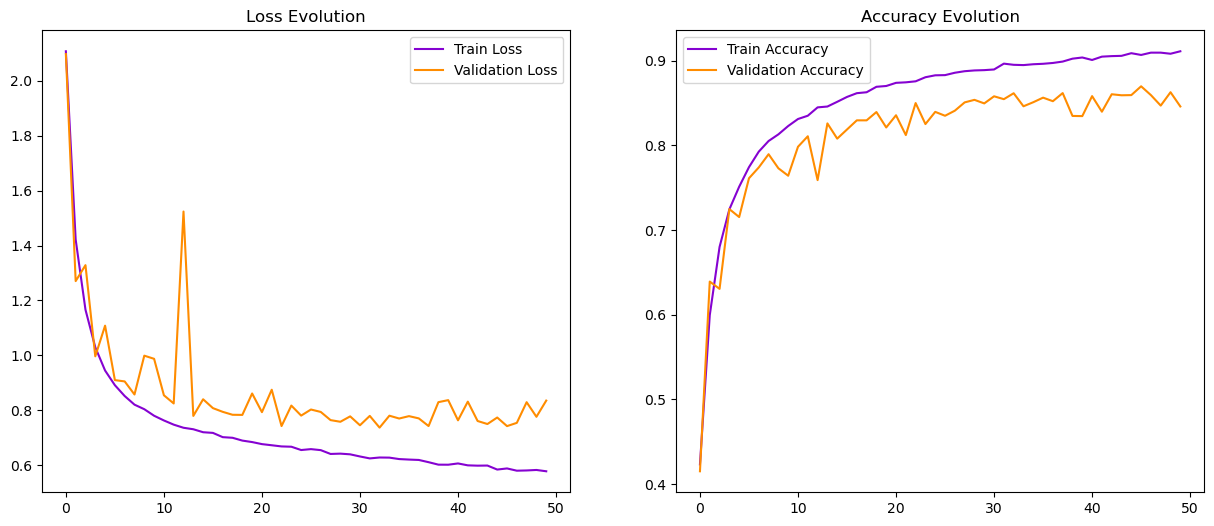

In [13]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [14]:
model.save('my_model.h5')

In [15]:
# Use the model to make predictions, evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 [==============================] - 25s 79ms/step - loss: 0.8458 - accuracy: 0.8453

Test Accuracy: 0.845300018787384
Test Loss:     0.8457569479942322


In [16]:
from sklearn.metrics import classification_report
import numpy as np

# Predicting probabilities for all 10 classes
test_predictions = model.predict(X_test)  # Outputs probabilities for all classes

# Convert probabilities to predicted class indices
predicted_classes = np.argmax(test_predictions, axis=1)  # Index of the highest probability

# Ensure y_test contains true class indices (0-9)
# If y_test is one-hot encoded, convert it to class indices:
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

# Generate the classification report
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
print("\nClassification Report:")
print(classification_report(y_test, predicted_classes, target_names=class_names))



Classification Report:
              precision    recall  f1-score   support

    Airplane       0.86      0.88      0.87      1000
  Automobile       0.94      0.93      0.94      1000
        Bird       0.83      0.69      0.76      1000
         Cat       0.81      0.60      0.69      1000
        Deer       0.86      0.84      0.85      1000
         Dog       0.77      0.83      0.80      1000
        Frog       0.69      0.97      0.80      1000
       Horse       0.89      0.91      0.90      1000
        Ship       0.93      0.91      0.92      1000
       Truck       0.94      0.90      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.84     10000
weighted avg       0.85      0.85      0.84     10000



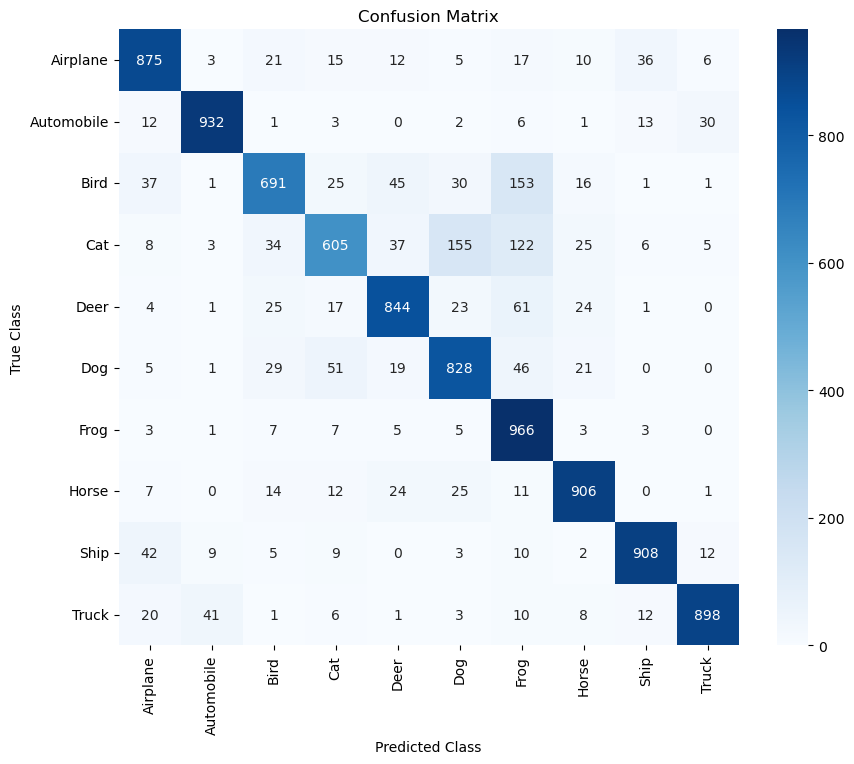


Classification Report:
              precision    recall  f1-score   support

    Airplane       0.86      0.88      0.87      1000
  Automobile       0.94      0.93      0.94      1000
        Bird       0.83      0.69      0.76      1000
         Cat       0.81      0.60      0.69      1000
        Deer       0.86      0.84      0.85      1000
         Dog       0.77      0.83      0.80      1000
        Frog       0.69      0.97      0.80      1000
       Horse       0.89      0.91      0.90      1000
        Ship       0.93      0.91      0.92      1000
       Truck       0.94      0.90      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.84     10000
weighted avg       0.85      0.85      0.84     10000



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predicting probabilities for all 10 classes
test_predictions = model.predict(X_test)  # Outputs probabilities for all classes

# Convert probabilities to predicted class indices
predicted_classes = np.argmax(test_predictions, axis=1)  # Index of the highest probability

# Ensure y_test contains true class indices (0-9)
# If y_test is one-hot encoded, convert it to class indices:
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot the confusion matrix
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, predicted_classes, target_names=class_names))


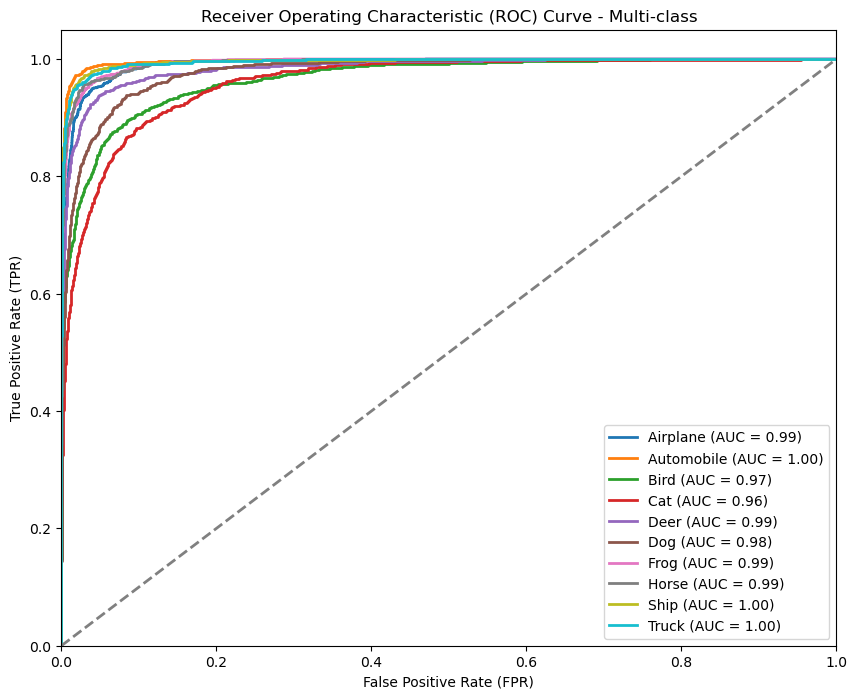

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

# List of class names
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer", 
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# One-hot encode y_test if it is not one-hot encoded already
encoder = OneHotEncoder(sparse=False)
y_test_one_hot = encoder.fit_transform(y_test.reshape(-1, 1))

# Get the predicted probabilities for each class
y_pred = model.predict(X_test)

# Number of classes
n_classes = y_test_one_hot.shape[1]

# Initialize dictionaries to store fpr, tpr, and roc_auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the random classifier diagonal line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class')
plt.legend(loc='lower right')
plt.show()


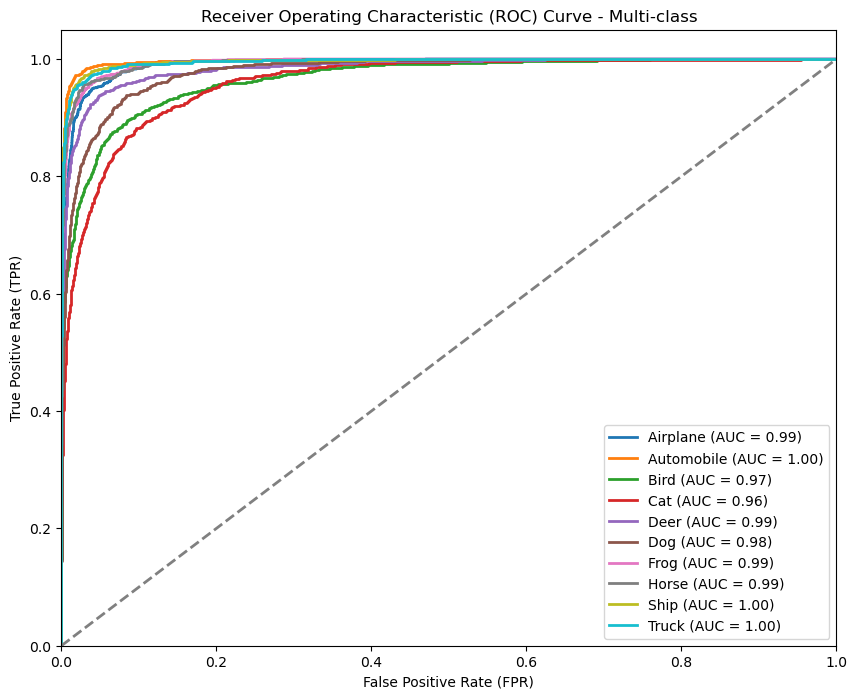

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

# List of class names
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer", 
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# One-hot encode y_test if it is not one-hot encoded already
encoder = OneHotEncoder(sparse=False)
y_test_one_hot = encoder.fit_transform(y_test.reshape(-1, 1))

# Get the predicted probabilities for each class
y_pred = model.predict(X_test)

# Number of classes
n_classes = y_test_one_hot.shape[1]

# Initialize dictionaries to store fpr, tpr, and roc_auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the random classifier diagonal line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class')
plt.legend(loc='lower right')
plt.show()


Predicted Class: Frog
Class Probabilities: [[3.1676658e-03 1.1476459e-04 3.2916060e-03 9.3305400e-03 1.9381648e-03
  7.6577062e-04 9.7998363e-01 5.2038489e-05 1.2307048e-03 1.2512204e-04]]


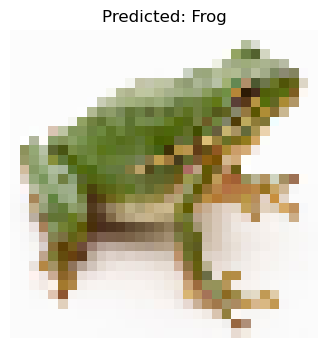

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess the image
img_path = 'Frog-1.jpg'
img = load_img(img_path, target_size=(32, 32))  # Resize to match model's input
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image if required by your model

# Predict the class probabilities
predictions = model.predict(img_array)

# Define class names (update with your actual class labels)
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", 
    "Dog", "Frog", "Horse", "Ship", "Truck"]  
if len(predictions[0]) != len(class_names):
    raise ValueError("Number of class names does not match the number of output predictions.")

# Get the predicted class
predicted_class = class_names[np.argmax(predictions)]

# Display the results
print(f"Predicted Class: {predicted_class}")
print(f"Class Probabilities: {predictions}")

# Plot the image with the prediction
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class}")
plt.show()

